In [1]:
import numpy as np
import pandas as pd
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import ast

In [2]:
def convert_tuple(x):
    try:
        return ast.literal_eval(x)
    except:
        return np.nan

converters = {str(i):convert_tuple for i in range(10)}

In [23]:
df = pd.read_csv('Data/VideosHD/Alex Pagulayan vs Shaun Wilkie - 9 Ball - 2020 Derby City Classic.csv', index_col=0, converters=converters)

In [4]:
pocket_loc = [(0,0), (-10,400), (0,800), (400,800), (410,400), (400,0)]

colors = ['white', 'yellow', 'blue', 'red', 'purple', 'orange', 'lawngreen', 'aqua', 'black', 'goldenrod']

def make_plot(balls):
    fig, ax = plt.subplots(figsize=(2,4))
    footspot = Circle((200, 600), 10, color='gray')
    pockets = [Circle(pts, 25, color='black') for pts in pocket_loc]
    _ = [ax.add_patch(p) for p in pockets]
    ax.set_facecolor('deepskyblue')
    plt.xlim((0,400))
    plt.ylim((0,800))
    ax.add_patch(footspot)
    
    for i in range(len(balls)-1):
        if balls[i] is not np.nan:
            ball = Circle(balls[i], 15, color=colors[i])
            ax.add_patch(ball)

    plt.show()

In [5]:
def shot_angle(cue, ball, pocket):
    '''
    Returns the shot angle, args must be numpy arrays
    '''
    v_c2b = cue - ball
    v_b2p = ball - pocket

    unit_v_c2b = v_c2b / np.linalg.norm(v_c2b)
    unit_v_b2p = v_b2p / np.linalg.norm(v_b2p)

    dot = np.dot(unit_v_c2b, unit_v_b2p)
    angle = np.arccos(dot)
    angle = np.degrees(angle)
    if angle > 90:  return angle - 90
    return angle

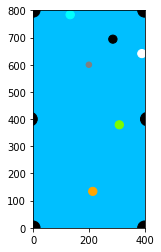

In [34]:
#df = df[df.iloc[:, 0].notnull()] # Remove frames with no cueball
make_plot(df.iloc[19800])

In [82]:
df.loc[1045]

0              (266, 200)
1              (204, 574)
2                     NaN
3              (206, 638)
4                     NaN
5                     NaN
6                     NaN
7                     NaN
8              (186, 607)
9              (210, 611)
orientation      Vertical
Name: 1045, dtype: object

In [6]:
def going_towards_pocket(prev, cur):
    '''
    Returns if the ball is heading towards a pocket, and the pocket index
    '''
    x1, y1 = prev
    x2, y2 = cur
    
    if x2 - x1 == 0:
        return False, (-1,-1)
    
    m = (y2 - y1) / (x2 - x1)
    
    b = y1 - m * x1

    # 1 if going right or 0 if not
    direction = 1 if x2 - x1 > 0 else 0
    
    # Only consider pockets in same direction ball is heading
    pockets = pocket_loc[3*direction:3*direction+3]
    
    for i, pock in enumerate(pockets, 3*direction):
        y_pred = m * pock[0] + b
        if np.absolute(y_pred - pock[1]) < 10:
            return True, i
    
    return False, (-1, -1)

In [7]:
def get_lowest_ball(row):
    for i, b in enumerate(row[1:-1], 1):
        if b is not np.nan:
            return i
    return -1

In [8]:
def moved(prev, cur, min_dist=5):
    if (prev is np.nan) or (cur is np.nan):
        return False
    return np.any(np.absolute(np.array(prev) - np.array(cur)) >  min_dist)

In [9]:
def get_shots(df):
    shots = []
    prev_row = None
    prev_ori = "Vertical"
    lowest_ball = None
    for i, row in df.iterrows():
        if prev_row is None:
            prev_row = row
            
        # Only check if orientation does not change
        if prev_row[-1] == row[-1]:
            if moved(prev_row[0], row[0]):
                lowest_ball = get_lowest_ball(row)
                if lowest_ball != -1: 
                    if moved(prev_row[lowest_ball], row[lowest_ball]):
                        going, pocket = going_towards_pocket(prev_row[lowest_ball], row[lowest_ball])
                        if going:
                            shots.append((np.array(prev_row[0]), (np.array(prev_row[lowest_ball])),  np.array(pocket_loc[pocket])))
        prev_row = row

    return shots

In [235]:
shots = get_shots(df)

In [239]:
angles = list(set([shot_angle(*shot) for shot in shots]))

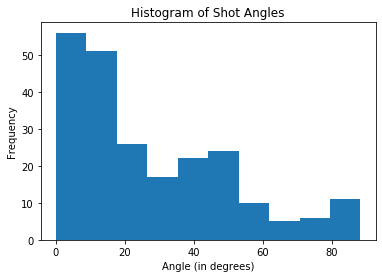

In [266]:
plt.hist(angles)
plt.title("Histogram of Shot Angles")
plt.xlabel("Angle (in degrees)")
plt.ylabel("Frequency")
plt.show()

In [267]:
np.mean(angles), np.median(angles)

(27.689122792478223, 20.277814553457414)

In [12]:
def get_angles(df):
    shots = get_shots(df)
    angles = list(set([shot_angle(*shot) for shot in shots]))
    return angles

In [10]:
import glob

files = glob.glob("Data/VideosHD/*.csv")

In [13]:
angles = []
for f in files:
    df = pd.read_csv(f, index_col=0, converters=converters)
    angles.extend(get_angles(df))

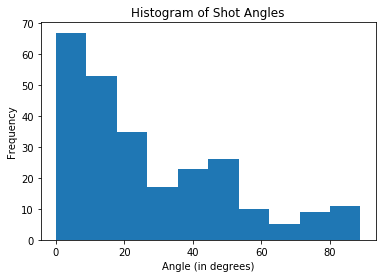

In [16]:
plt.hist(angles)
plt.title("Histogram of Shot Angles")
plt.xlabel("Angle (in degrees)")
plt.ylabel("Frequency")
plt.show()

In [14]:
np.mean(angles), np.median(angles)

(27.244633854594692, 19.23557570517104)